In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import warnings
from countrygroups import EUROPEAN_UNION
from countryinfo import CountryInfo

#managing warnings(ignoring them mostly)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)     
warnings.filterwarnings('ignore')

#setting display options
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (25, 14)
plt.style.use('seaborn-whitegrid')

from matplotlib.pyplot import cm
color = 'tab20c'



# Introduction to The Project

Thbrief of this project states that we must focus on the comparison of one irish agricultural sector to similar sectors worldwide. To begin with we will simply start by using data from FAOSTAT to compare the production of dairy products in ireland and other EU countries, after which we will extend our analysis to other countries around the world, such as USA or NZ. A handful of machine learning techniques will be used to make predictions regarding the milk production in these countries, most likely in the units of L/Hectare or L/cow. Throughout this project we will include sentiment analysts so that we may determine if changes in public sentiment reflect the currrent ,arket conditions.

### Importing the Datasets

In [2]:
# importinjg the land data
land_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\FAOSTAT_Land_Use.csv', on_bad_lines='skip')

# importing dairy products data
dairy_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\FAOSTAT_DAIRY_DATA.csv', on_bad_lines='skip')

#importing producer price data
price_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Producer_milk_prices.csv', on_bad_lines='skip')

#importing export data
export_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\import_export_prices_v1.csv', on_bad_lines='skip')

#replace czechia with Czech Republic in all dataframes
land_df = land_df.replace('Czechia', 'Czech Republic')
dairy_df = dairy_df.replace('Czechia', 'Czech Republic')
price_df = price_df.replace('Czechia', 'Czech Republic')
export_df = export_df.replace('Czechia', 'Czech Republic')

### First we will Format all the data we need and merge it into a single dataframe. This should streamline things later on in the project

In [3]:
dairy_df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1961,1961,tonnes,7000.0,I,Imputed value
1,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1962,1962,tonnes,7000.0,I,Imputed value
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1963,1963,tonnes,8000.0,I,Imputed value
3,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1964,1964,tonnes,8000.0,I,Imputed value
4,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1965,1965,tonnes,9000.0,I,Imputed value


Okay, it looks like there are some years where the values for dairy products were not recorded. We could impute these, however this may cause bias to appear in the data 

In [4]:
#find unique of dairy items in the dataset, and filter only the ones we want to see
print(dairy_df['Item'].unique())
items = ['Raw milk of cattle']

['Butter of cow milk' 'Cattle' 'Raw milk of cattle' 'Skim milk of cows'
 'Cheese from whole cow milk' 'Cheese from skimmed cow milk'
 'Skim milk and whey powder' 'Buttermilk, dry']


In [5]:
# what are the uniquwe year values?
dairy_df['Year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=int64)

I only want eu countries here. so i will create a list of country names and then filter the land_df dataframe by these

In [6]:
#filtering the data to only include the EU member states and items of interest

milk_eu_head = dairy_df[(dairy_df['Area'].isin(EUROPEAN_UNION.names)) & (dairy_df['Item'].isin(items)) & (dairy_df['Unit'].isin(['Head']))]
milk_eu_head['key'] = milk_eu_head['Area'] + milk_eu_head['Year'].astype(str)
milk_eu_tonne = dairy_df[(dairy_df['Area'].isin(EUROPEAN_UNION.names)) & (dairy_df['Item'].isin(items)) & (dairy_df['Unit'].isin(['tonnes']))]
milk_eu_tonne['key'] = milk_eu_tonne['Area'] + milk_eu_tonne['Year'].astype(str)

#merging the two datasets to get the total milk production in tonnes and the number of cows in one dataset
milk_eu = pd.merge(milk_eu_head, milk_eu_tonne[['key','Unit', 'Value']], on='key', how='inner')
milk_eu.drop(['Unit_x', 'Unit_y'], axis=1, inplace=True)
milk_eu.rename(columns={'Value_x':'Head', 'Value_y':'Tonne'}, inplace=True)
milk_eu.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne
0,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1961,1961,1127559.0,A,Official figure,Austria1961,2901500.0
1,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1962,1962,1136353.0,A,Official figure,Austria1962,3004900.0
2,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1963,1963,1124404.0,A,Official figure,Austria1963,3049200.0
3,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1964,1964,1113920.0,A,Official figure,Austria1964,3127600.0
4,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1965,1965,1110080.0,A,Official figure,Austria1965,3209200.0


Now that we have the data mostly in the format, and including only the features that we want, we are able to visualise the milk yield in tonnes per country.

In [7]:
#converting country name to country code
import pycountry
def country_name_to_country_code(country_name):
    country_code = pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    return country_code

#now applying this to the data
milk_eu['Country Code'] = milk_eu['Area'].apply(country_name_to_country_code)


Including a herd size as a separate column

Now that the dataset contains only thye values that we are interested in working with, we can check for obvious issues. 

In [8]:
#checking for null values
milk_eu.isnull().sum()

Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
Item                0
Year Code           0
Year                0
Head                0
Flag                0
Flag Description    0
key                 0
Tonne               0
Country Code        0
dtype: int64

In [9]:
milk_eu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1295 entries, 0 to 1294
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       1295 non-null   object 
 1   Domain            1295 non-null   object 
 2   Area Code (M49)   1295 non-null   int64  
 3   Area              1295 non-null   object 
 4   Element Code      1295 non-null   int64  
 5   Element           1295 non-null   object 
 6   Item Code (CPC)   1295 non-null   float64
 7   Item              1295 non-null   object 
 8   Year Code         1295 non-null   int64  
 9   Year              1295 non-null   int64  
 10  Head              1295 non-null   float64
 11  Flag              1295 non-null   object 
 12  Flag Description  1295 non-null   object 
 13  key               1295 non-null   object 
 14  Tonne             1295 non-null   float64
 15  Country Code      1295 non-null   object 
dtypes: float64(3), int64(4), object(9)
memory 

In [10]:
milk_eu.describe()

,Area Code (M49),Element Code,Item Code (CPC),Year Code,Year,Head,Tonne
count,1295.000000,1295.0,1295.0,1295.000000,1295.000000,1.295000e+03,1.295000e+03
mean,395.471042,5318.0,2211.0,1993.213900,1993.213900,1.390541e+06,5.919772e+06
std,209.048076,0.0,0.0,17.268311,17.268311,1.830415e+06,7.747366e+06
min,40.000000,5318.0,2211.0,1961.000000,1961.000000,3.096000e+03,1.126700e+04
25%,246.000000,5318.0,2211.0,1978.500000,1978.500000,2.583555e+05,8.438370e+05
50%,372.000000,5318.0,2211.0,1995.000000,1995.000000,6.233580e+05,3.127600e+06
75%,616.000000,5318.0,2211.0,2008.000000,2008.000000,1.693288e+06,6.335155e+06
max,752.000000,5318.0,2211.0,2020.000000,2020.000000,8.050077e+06,3.453850e+07


In [11]:
#I want to check if there are any years missing form the dataset. I will not try to fill in the missing values, but I just
#need to know for planning purposes
#to do this we will just loop over every country and return the list of the coprresponding numbero of years. 
#there should be 60 years for each country
for i in milk_eu['Area'].unique():
    print(i, len(milk_eu[milk_eu['Area'] == i]['Year'].unique()))

Austria 60
Belgium 21
Bulgaria 60
Croatia 29
Cyprus 60
Denmark 60
Estonia 29
Finland 60
France 60
Germany 60
Greece 60
Hungary 60
Ireland 60
Italy 60
Latvia 29
Lithuania 29
Luxembourg 21
Malta 60
Netherlands 60
Poland 60
Portugal 60
Romania 60
Slovakia 28
Slovenia 29
Spain 60
Sweden 60


Above show the number of rccords for each country. There are 9 countries that are missing approximately half of the number of reccords found in others. This could be due to one of two reasons...
1) The countries are quite young and simply did not exist for earlier recordings
2) There are simply no reccords available for the specified datesa due to clerical issues.

It will be very diffocult to faitlfully impute values of countries where it COULD be possible. so we are not going to carry out this step, this is simply because we dont need this data.

In [12]:
#plotting the data on map]
def plot_map(measure, title):
    import plotly.express as px
    fig = px.choropleth(milk_eu, locations="Country Code", color=measure,
                    hover_name="Area", animation_frame="Year",
                    color_continuous_scale=px.colors.sequential.YlGnBu)

    fig.update_layout(title_text= title, geo_scope='europe', width = 1000, height = 600)
    fig.show()


In [13]:
#mapping milk production
plot_map('Tonne', 'Milk production in EU member states')

In [14]:
#looking at herd size in EU member states
plot_map('Head', 'Herd size in EU member states')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


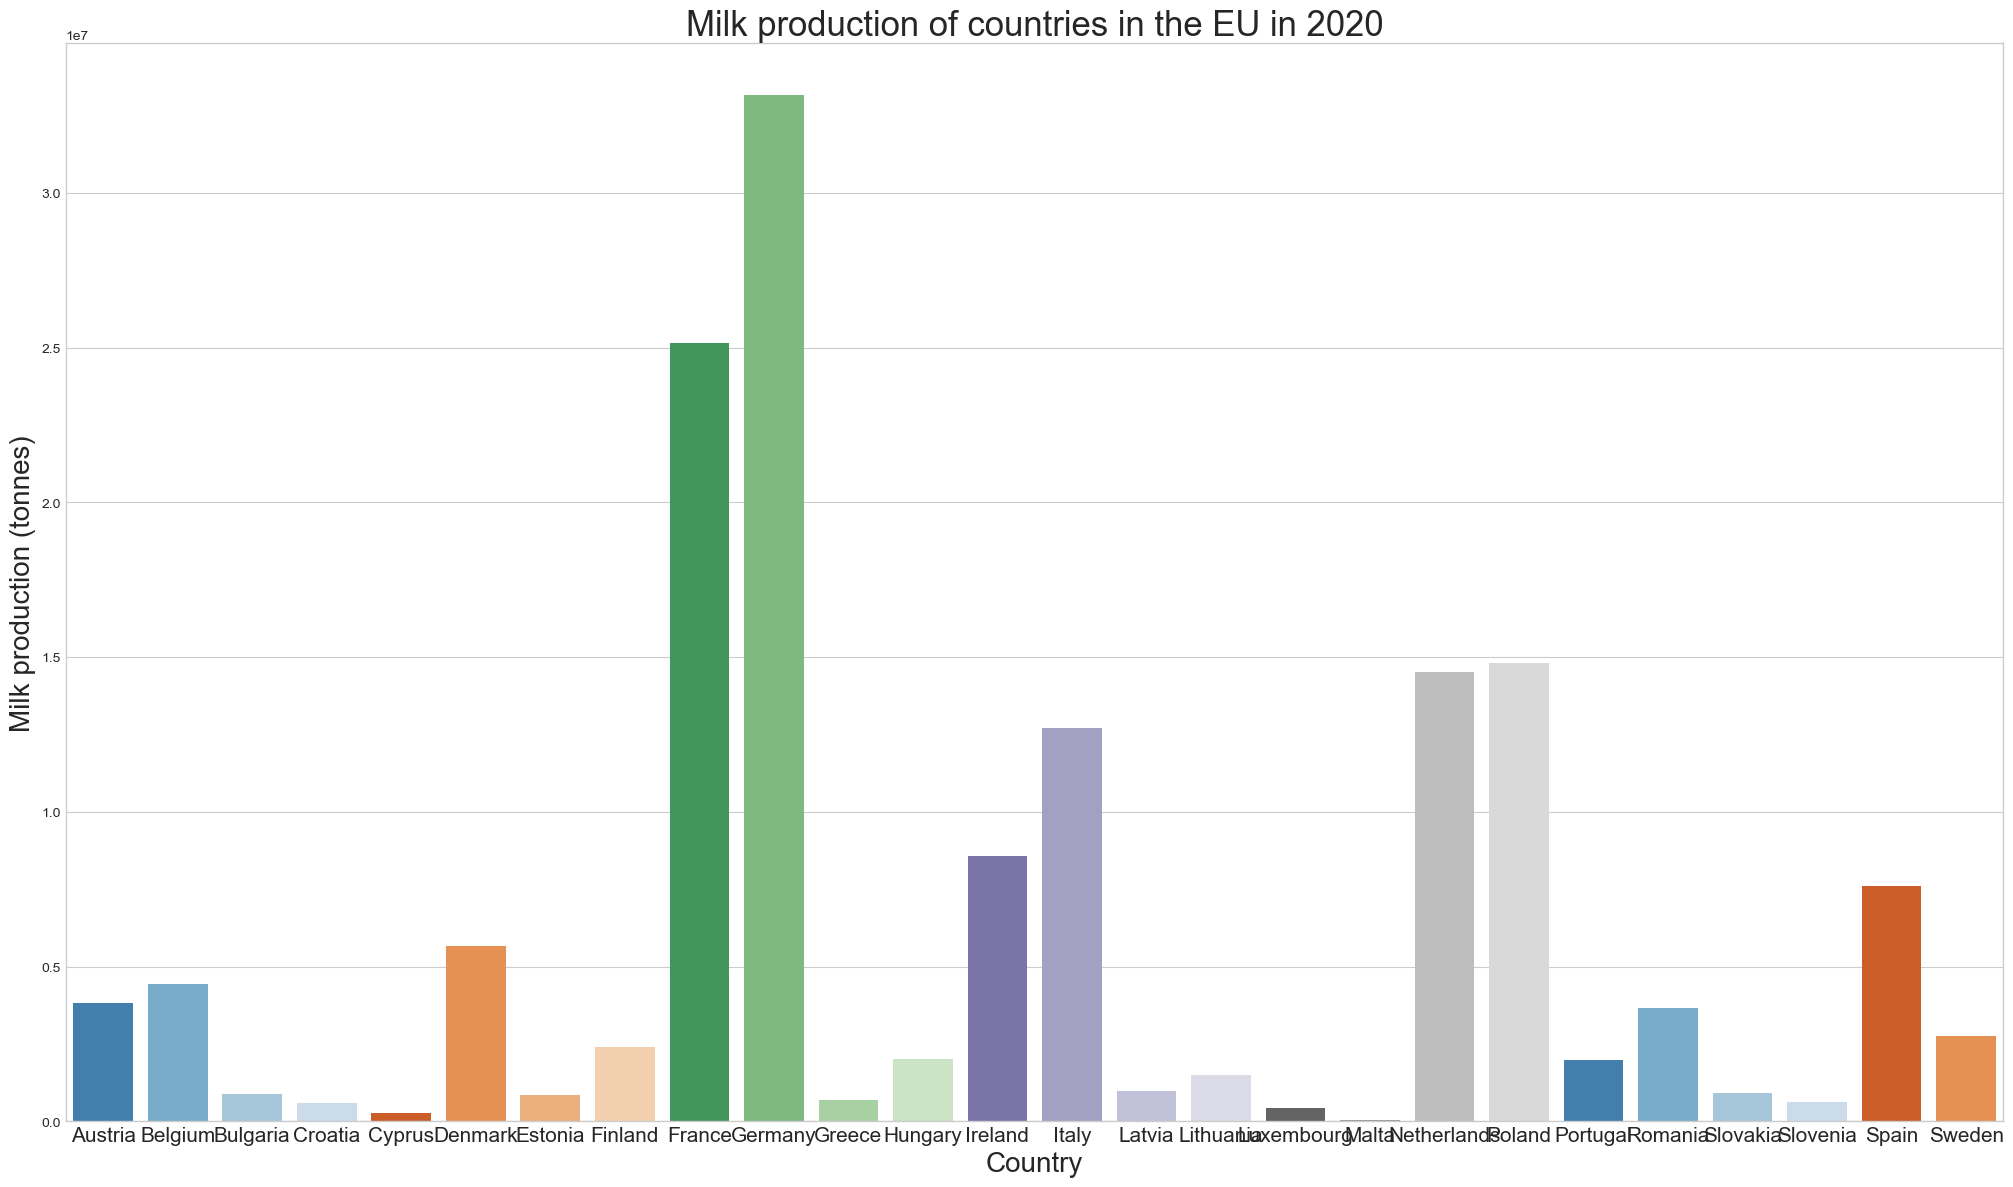

In [15]:
#this barplot is produced to show the prefoprmanxce of the top 8 milk producing countries in the EU in 2020.
#Ireland is there wohoo!
sns.barplot(x='Area', y='Tonne', data=milk_eu[(milk_eu['Year'] == 2020 )], palette = color) 
plt.title('Milk production of countries in the EU in 2020', fontsize=25)
plt.xlabel('Country', fontsize=20)
plt.ylabel('Milk production (tonnes)', fontsize=20)
plt.xticks(fontsize=15)
plt.legend(loc='upper right', fontsize=15)

### Plotting the change in milk procuction for these countries over all recorded time

To do this we will use a for loop. This requires that we make a list of the top ranking countries & a list for each year that we investigate. We will then use a for loop to iterate over these countrues, querying the production values for every year of each. An if statement is added as a perecautionm to ensure that muliiple values arenjt being appended to the milk_volume list at a time. These are then plot directly from the loop, but we also save them to a dictionary incase they are needed later on in the project.

In [16]:
 #creating list of countries and years
countries = milk_eu[(milk_eu['Year'] == 2020)]['Area'].tolist()
years = milk_eu['Year'].unique().tolist()
 def trend_plot(df, measure, title, y_label):

    #defining a dictionary to store the data
    milk = {}
    #looping through the countries and years to get the data
    cmap = cm.tab20c(np.linspace(0, 1, len(countries)))
    for i, h in zip(countries, cmap):
        milk_volume = [] #creating a list to store the data
        year = []
        for j in years: 
            value = df[(df['Area'] == i) & (df['Year'] == j)][measure]  #getting the value
            if len(value) ==1:#checking if the value is present and length is 1
                milk_volume.append(value)
                year.append(j)

            else:
                pass #if not present, print error
        milk[i] = milk_volume #adding the data to the dictionary
        plt.plot(year, milk_volume, '--o', label=i, color = h)#plotting the data

    #styling the plot
    plt.legend(fontsize = 15)
    plt.title(title, fontsize=25)
    plt.xlabel('Year', fontsize=20)
    plt.ylabel(y_label, fontsize=20)

    plt.show()

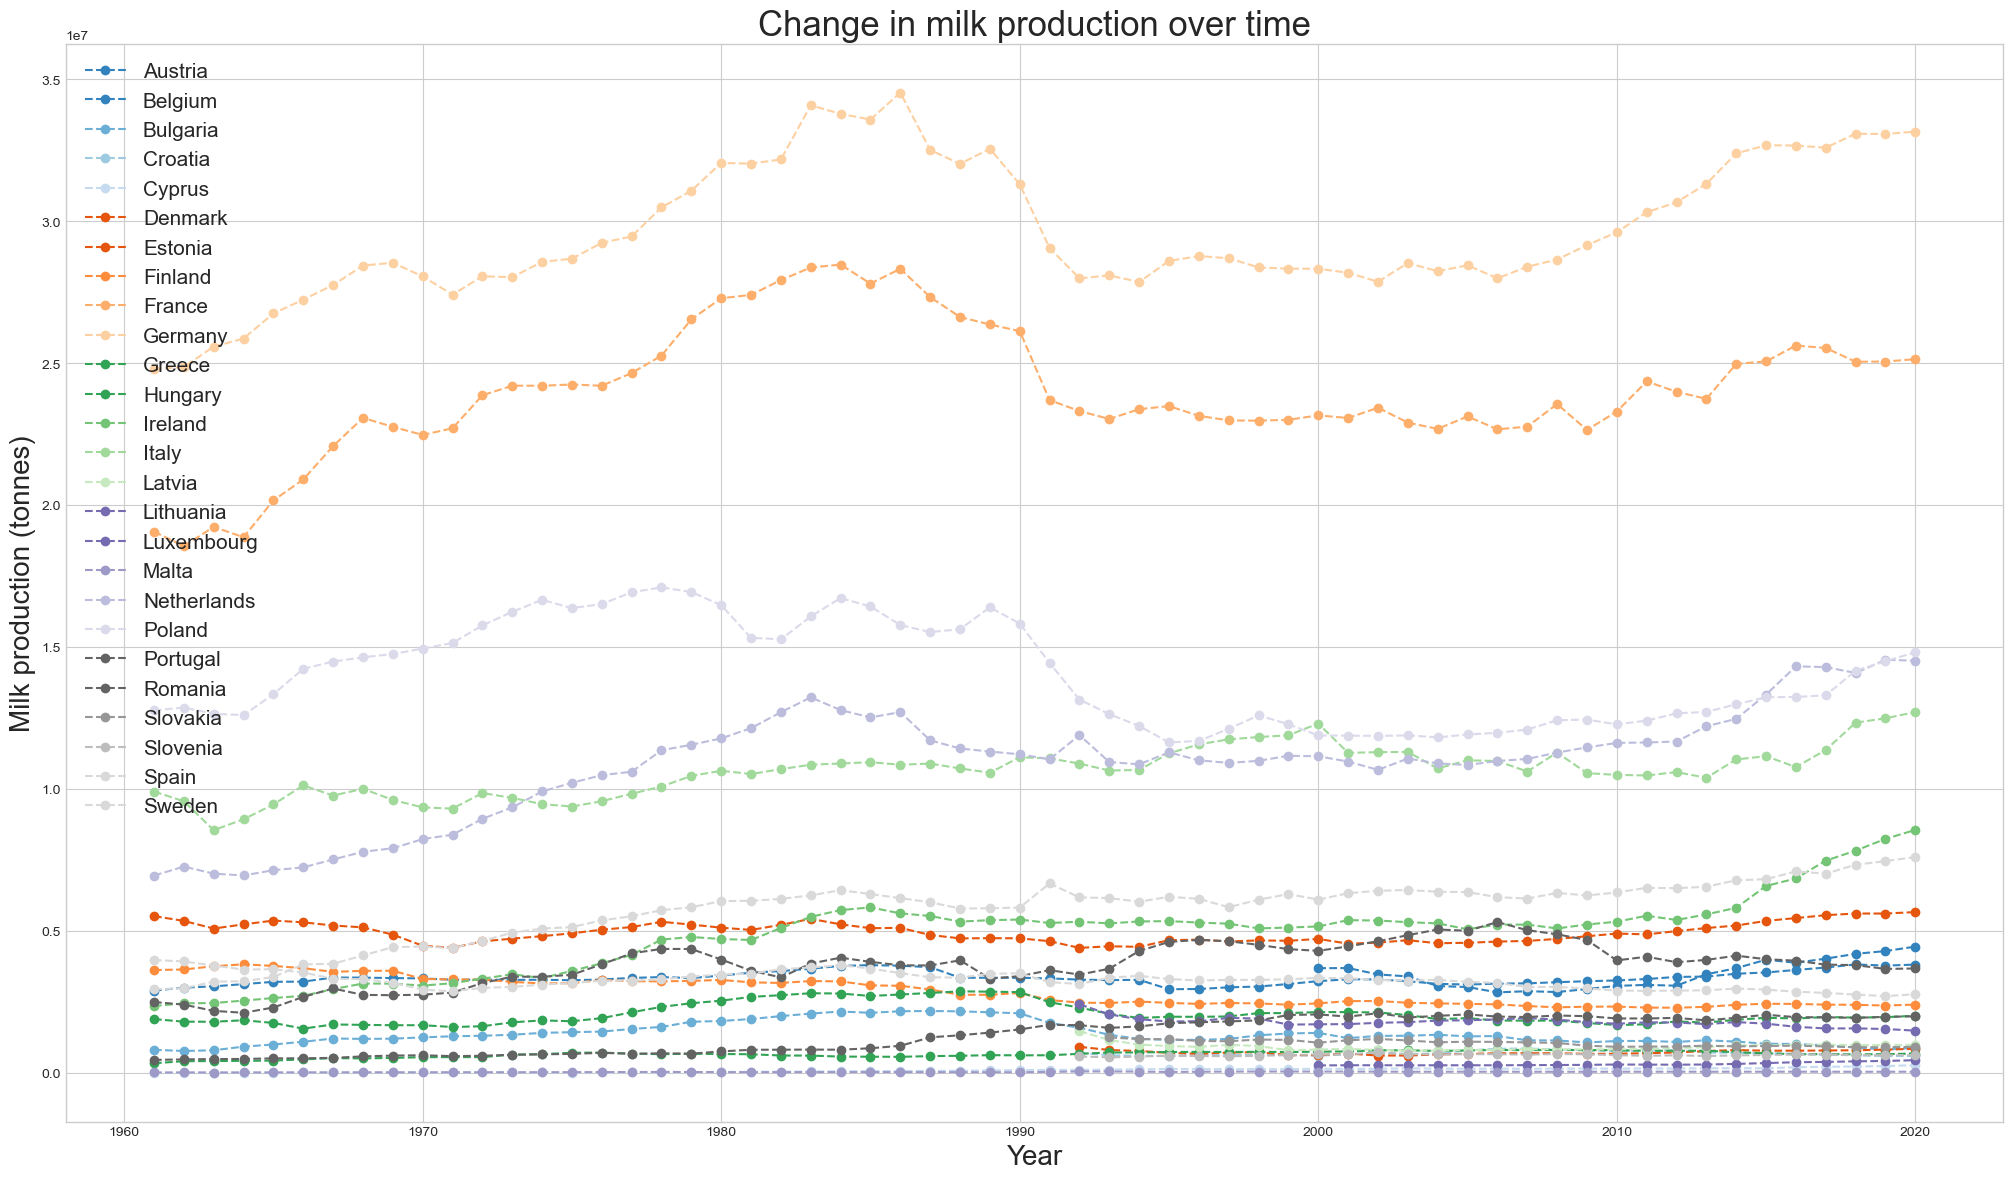

In [17]:
#plotting change in milk production over time
trend_plot(milk_eu, 'Tonne', 'Change in milk production over time', 'Milk production (tonnes)')

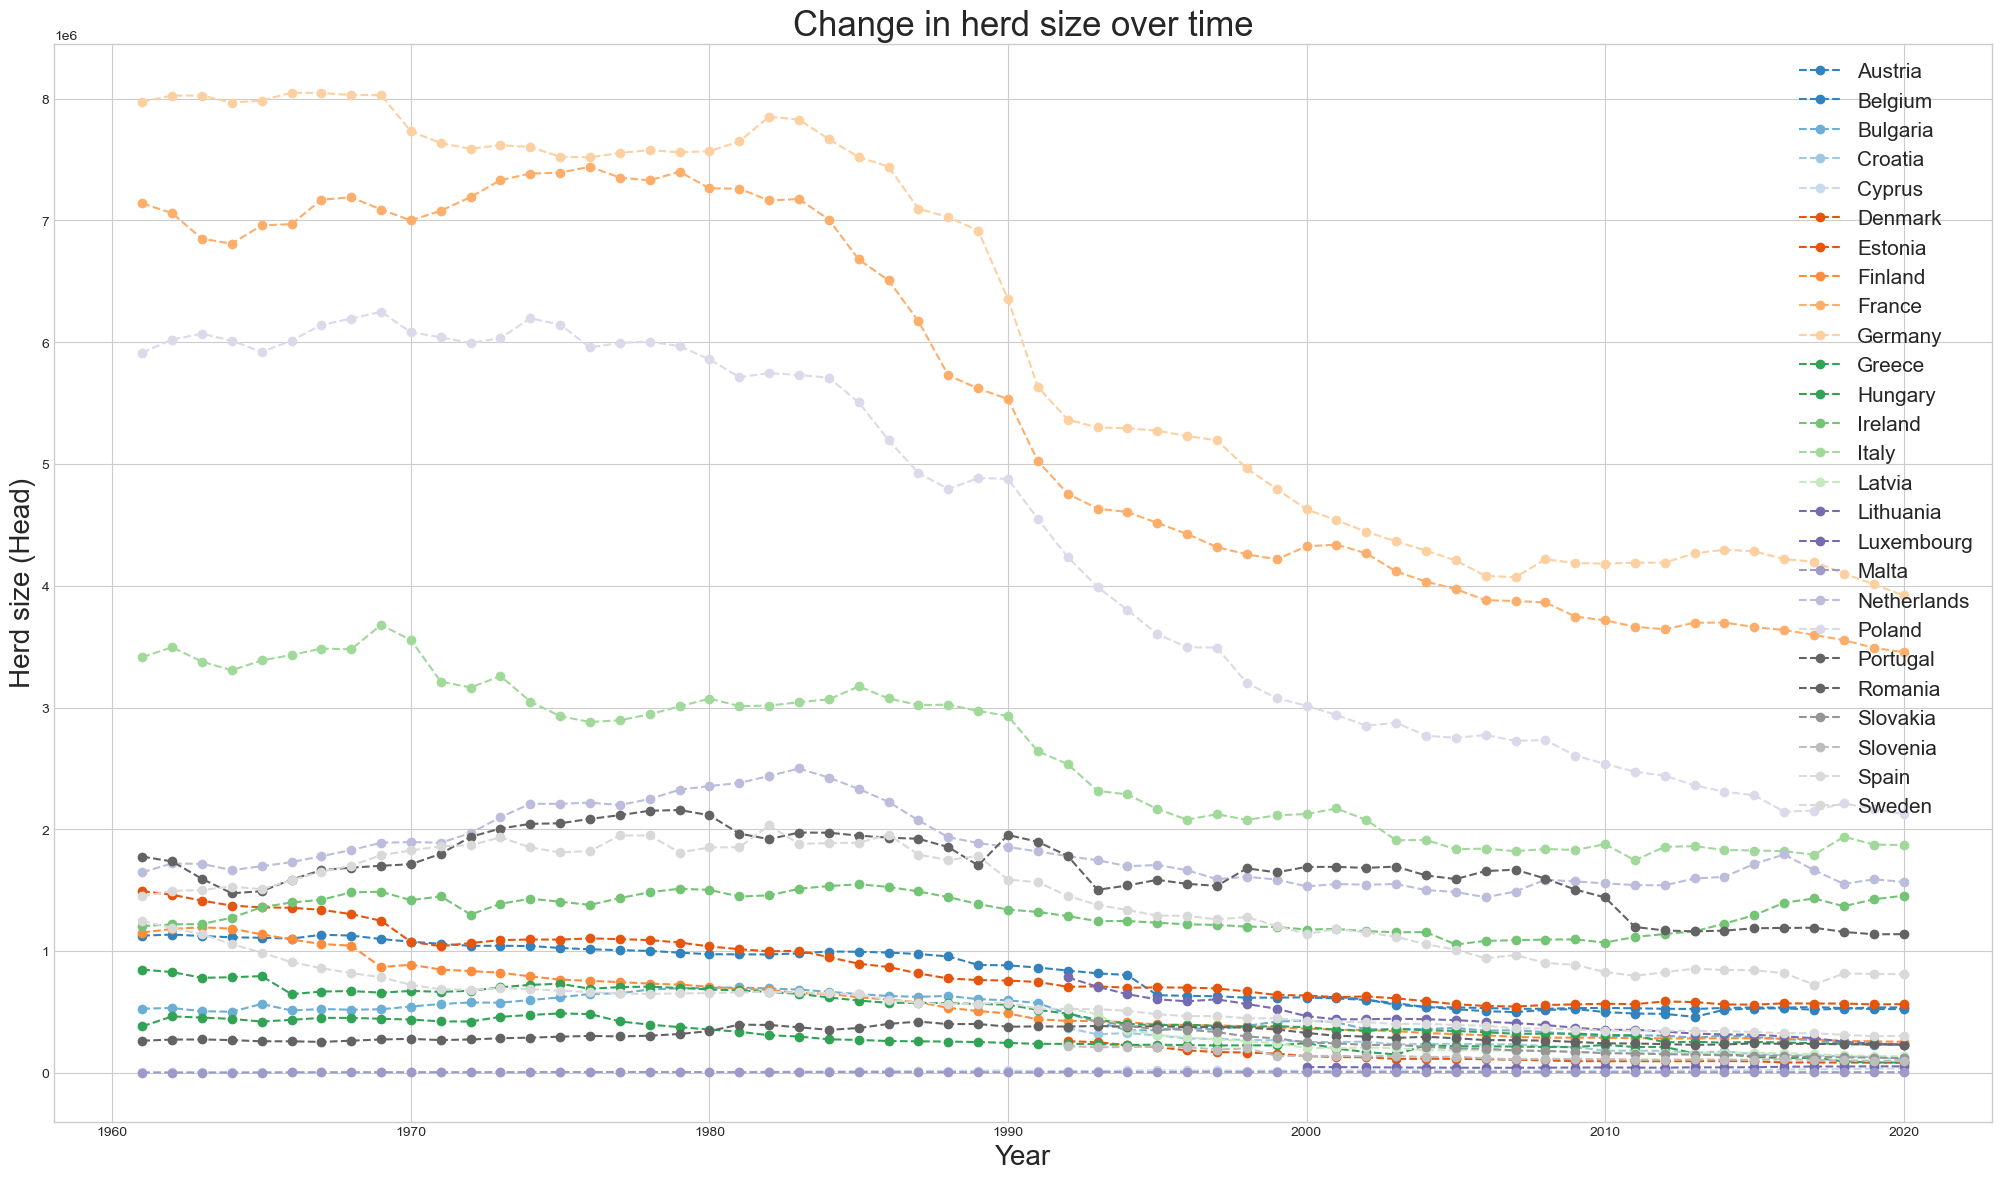

In [18]:
#plotting change in herd size over time
trend_plot(milk_eu, 'Head', 'Change in herd size over time', 'Herd size (Head)')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 [Text(0, 0, 'Austria'),
  Text(1, 0, 'Belgium'),
  Text(2, 0, 'Bulgaria'),
  Text(3, 0, 'Croatia'),
  Text(4, 0, 'Cyprus'),
  Text(5, 0, 'Denmark'),
  Text(6, 0, 'Estonia'),
  Text(7, 0, 'Finland'),
  Text(8, 0, 'France'),
  Text(9, 0, 'Germany'),
  Text(10, 0, 'Greece'),
  Text(11, 0, 'Hungary'),
  Text(12, 0, 'Ireland'),
  Text(13, 0, 'Italy'),
  Text(14, 0, 'Latvia'),
  Text(15, 0, 'Lithuania'),
  Text(16, 0, 'Luxembourg'),
  Text(17, 0, 'Malta'),
  Text(18, 0, 'Netherlands'),
  Text(19, 0, 'Poland'),
  Text(20, 0, 'Portugal'),
  Text(21, 0, 'Romania'),
  Text(22, 0, 'Slovakia'),
  Text(23, 0, 'Slovenia'),
  Text(24, 0, 'Spain'),
  Text(25, 0, 'Sweden')])

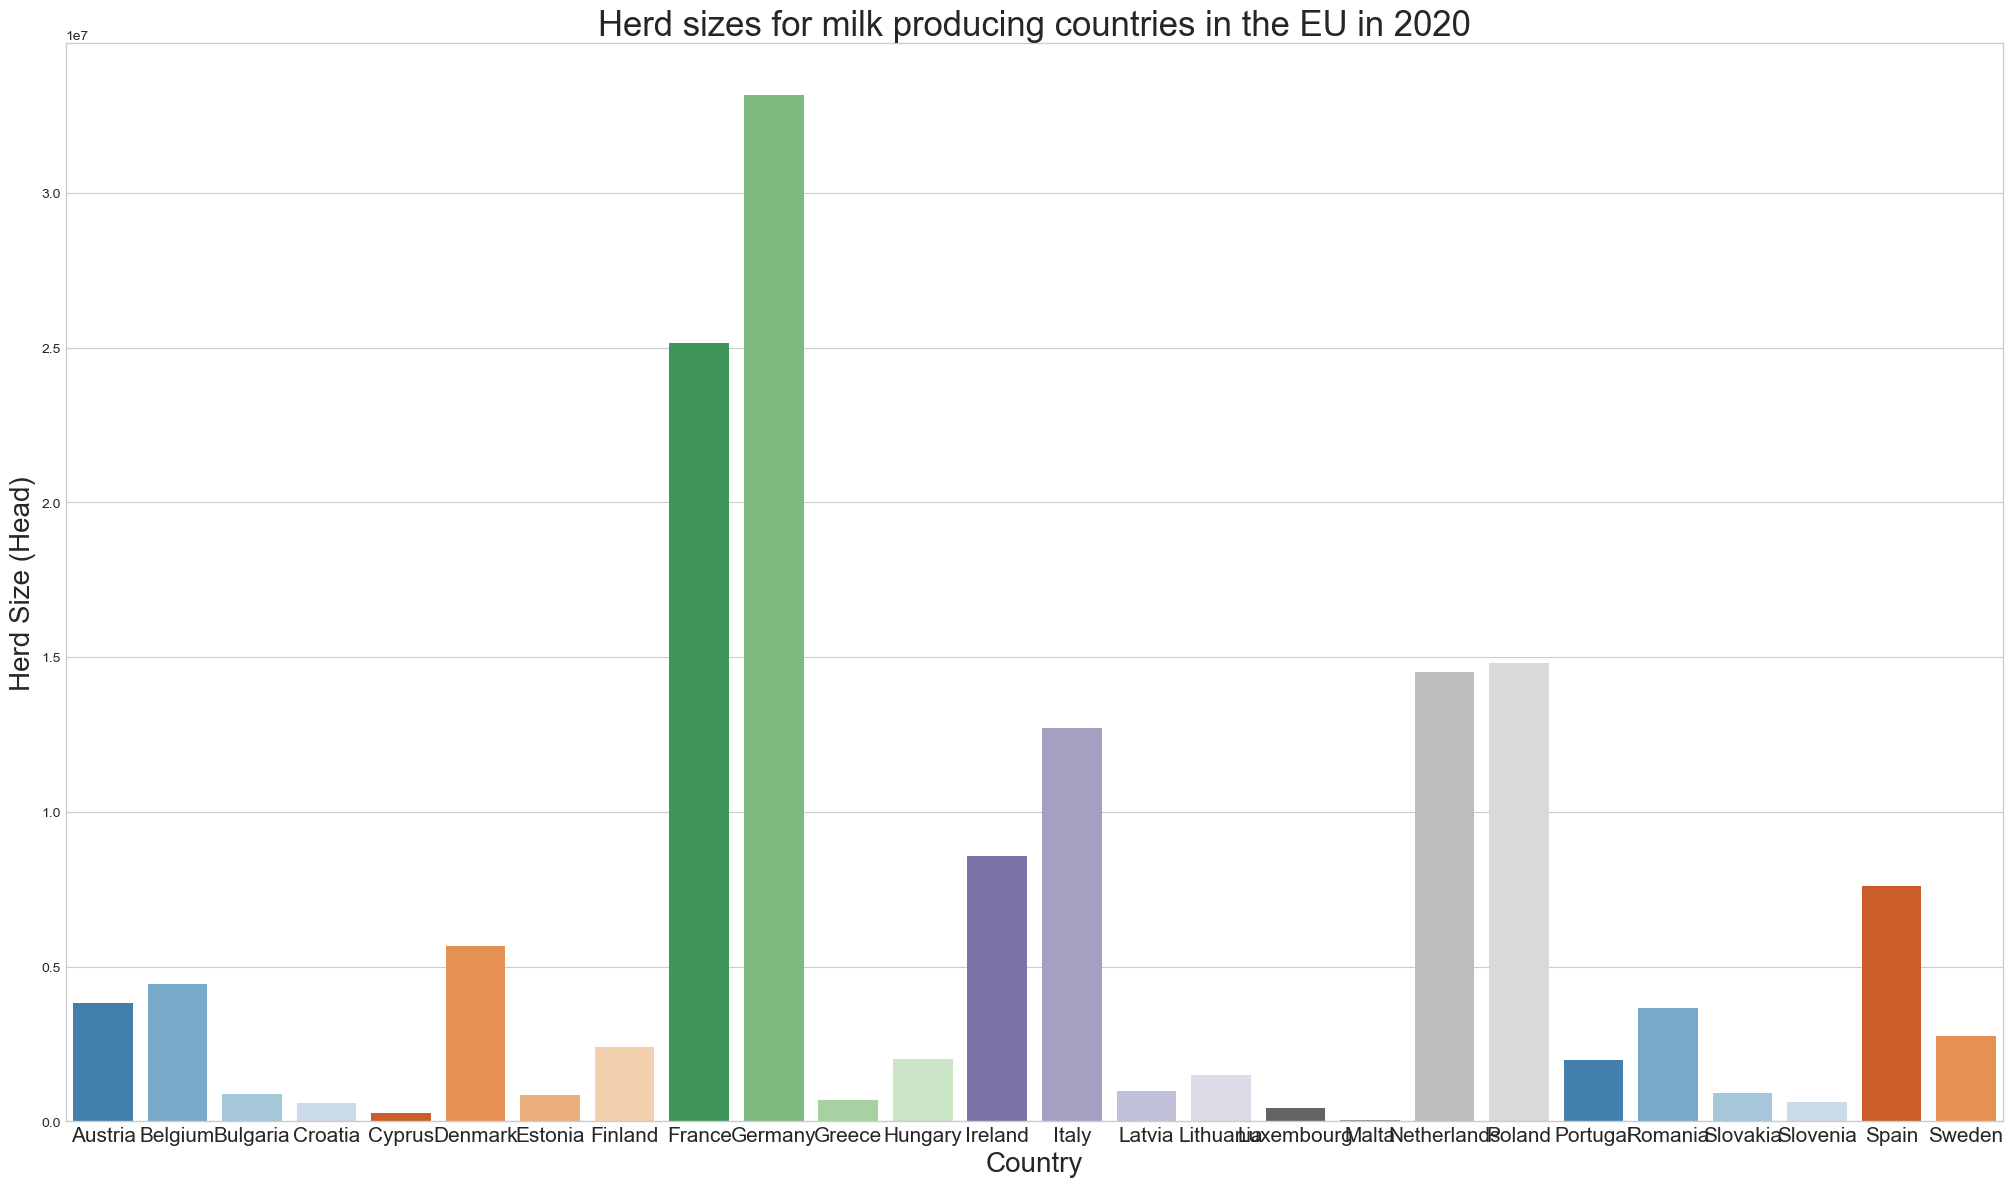

In [19]:
#lets plot the herd sizes fpr these countries
sns.barplot(x='Area', y='Tonne', data=milk_eu[(milk_eu['Year'] == 2020 )& (milk_eu['Area'].isin(countries))], palette = color)
plt.title('Herd sizes for milk producing countries in the EU in 2020', fontsize=25)
plt.xlabel('Country', fontsize=20)
plt.ylabel('Herd Size (Head)', fontsize=20)
plt.xticks(fontsize = 15)


Convert tonnes to litres and look at the litre/cow over the years. to do this we simply look back to our physics 1 class and remember the following formula,

$$ V = \frac{m}{\rho{}} $$

where V is volume, m is mass. and $\rho{}$ is the density. The density for raw milk will be 1.027kg/m3 on average at a temperature of 20c. 

nice to finally be making good use of that physics degree...

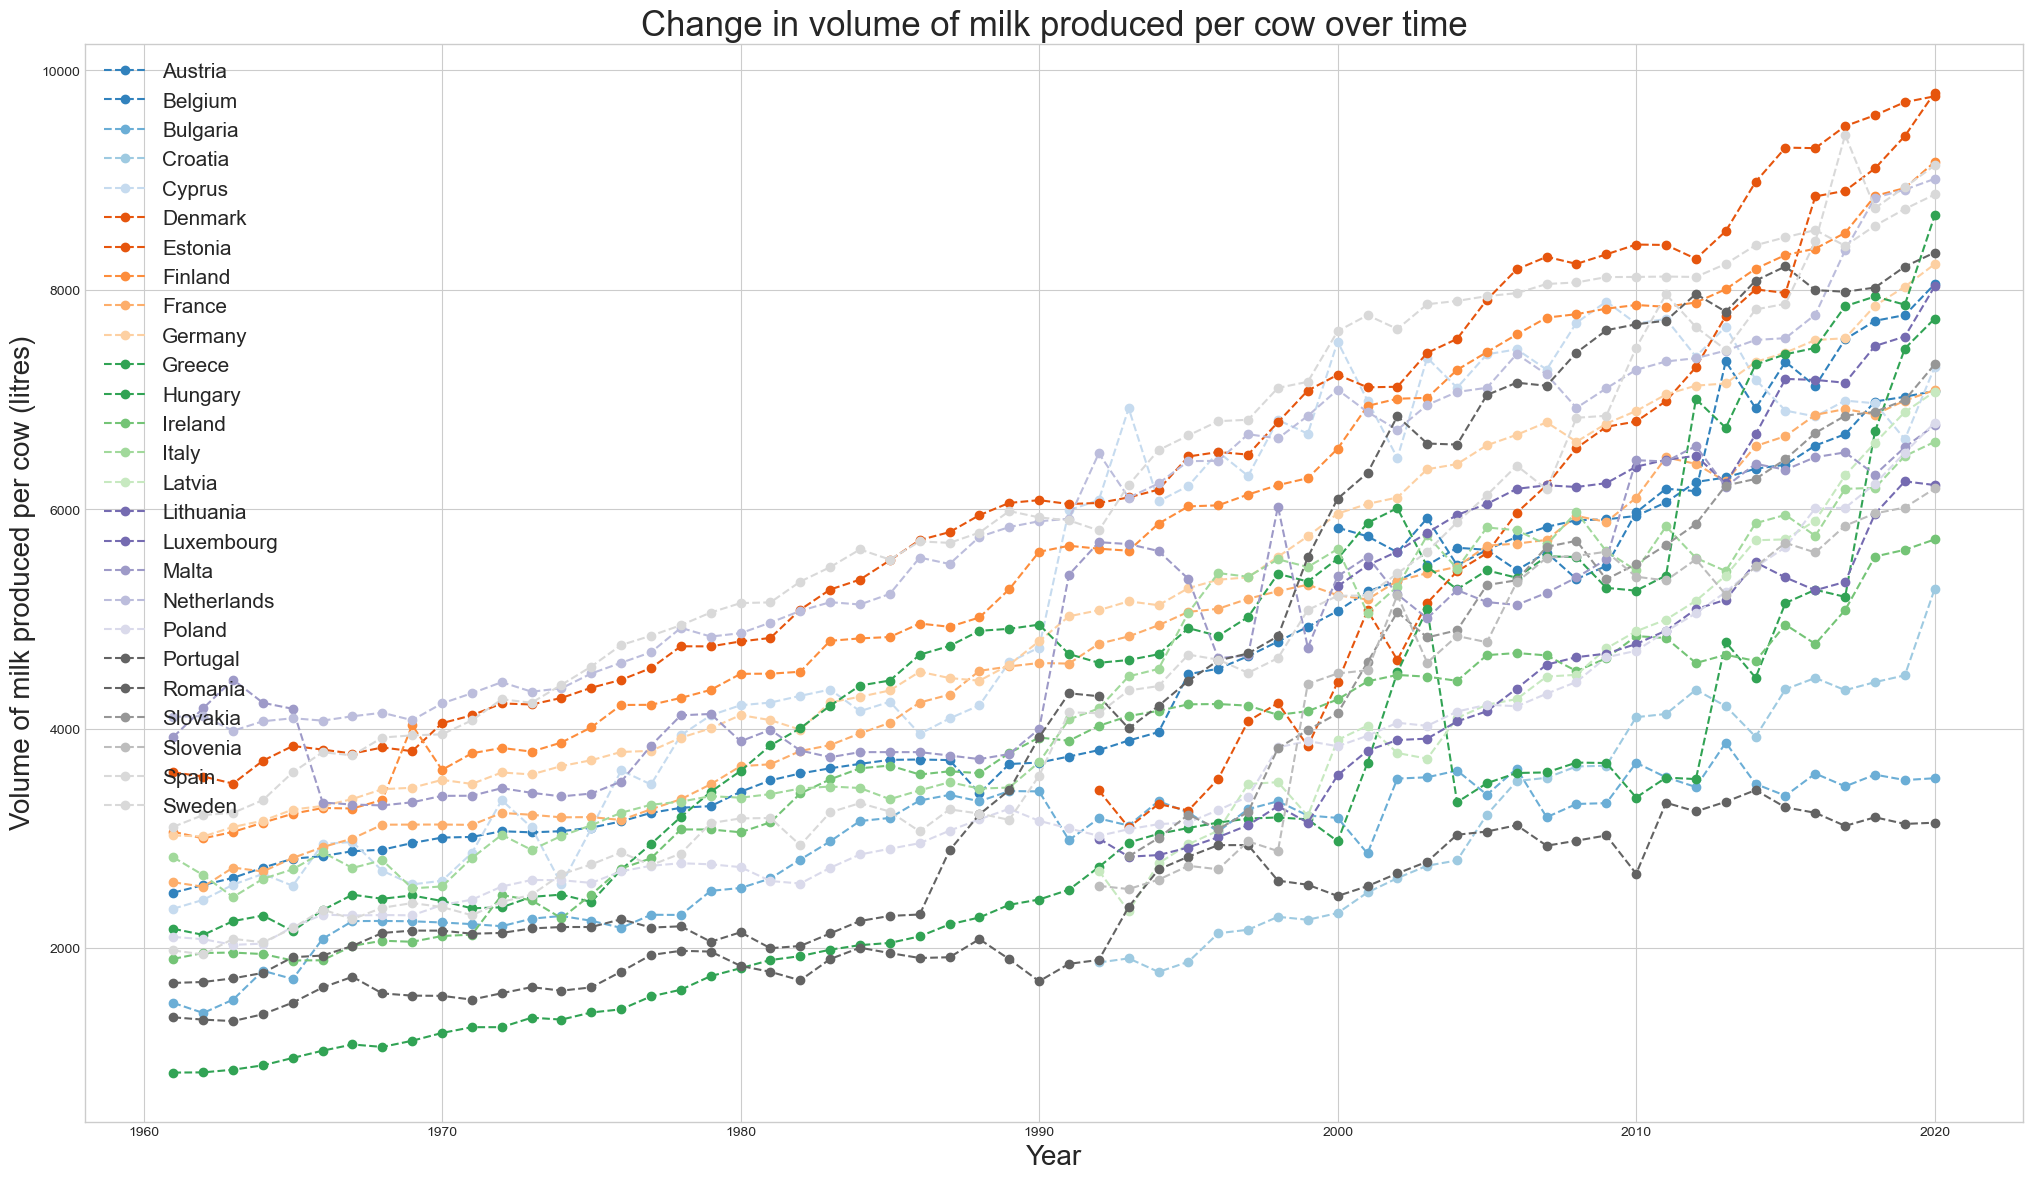

In [20]:
def volume(x):
    return x*1000/1.027

milk_eu['volume'] = milk_eu['Tonne'].apply(volume)
milk_eu['volume/cow'] = milk_eu['volume']/milk_eu['Head']
milk_eu

#plotting the volume of milk produced per cow
trend_plot(milk_eu, 'volume/cow', 'Change in volume of milk produced per cow over time', 'Volume of milk produced per cow (litres)')


# Lets take a while to look at the Land use data now.

In [21]:
#first we eill take a look at the data
land_df[(land_df['Area'] == 'Ireland') & (land_df['Item'] == 'Land under temp. meadows and pastures')]['Year'].unique()


array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

Having looked at this data we can see that the land usage for temporary pastures & perminant pastures are given in a single column. We will first splot these into separate columns and add these together to get an idea of the TOTAL pasture area. To do this we will create two separate dataframes and merge them 

In [22]:
#isolating permanent pasture
perminant_pasture = land_df[land_df['Item'] == 'Land under perm. meadows and pastures']
#making a key column to merge the data
perminant_pasture['key'] = perminant_pasture['Area'] + perminant_pasture['Year'].astype(str)
#isolating temporary pasture
temp_pasture = land_df[land_df['Item'] == 'Land under temp. meadows and pastures']
#making a key column to merge the data
temp_pasture['key'] = temp_pasture['Area'] + temp_pasture['Year'].astype(str)
#merging the data
total_pasture = pd.merge(perminant_pasture, temp_pasture[['key', 'Item', 'Value']], on='key', how='left')
#isolating the top 8 EU member states for milk production
total_pasture = total_pasture[(total_pasture['Area'].isin(countries))]
#dropping the unnecessary columns
total_pasture.drop(columns=['Item_x', 'Item_y'], inplace=True)
#renaming the columns
total_pasture.rename(columns={'Value_x': 'Permanent Pasture', 'Value_y': 'Temporary Pasture'}, inplace=True)
#replace NaN with 0 in the temporary pasture column
total_pasture['Temporary Pasture'].fillna(0, inplace=True)
#calculating the total pasture
total_pasture['Total Pasture'] = total_pasture['Permanent Pasture'] + total_pasture['Temporary Pasture']
#converting the data to hectares
total_pasture['Total Pasture'] = total_pasture['Total Pasture'].apply(lambda x: x*1000)
total_pasture.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Year Code,Year,Unit,Permanent Pasture,Flag,Flag Description,key,Temporary Pasture,Total Pasture
569,RL,Land Use,40,Austria,5110,Area,6655,1961,1961,1000 ha,1801.4,A,Official figure,Austria1961,0.0,1801400.0
570,RL,Land Use,40,Austria,5110,Area,6655,1962,1962,1000 ha,1785.0,A,Official figure,Austria1962,0.0,1785000.0
571,RL,Land Use,40,Austria,5110,Area,6655,1963,1963,1000 ha,1768.8,A,Official figure,Austria1963,0.0,1768800.0
572,RL,Land Use,40,Austria,5110,Area,6655,1964,1964,1000 ha,1752.5,A,Official figure,Austria1964,0.0,1752500.0
573,RL,Land Use,40,Austria,5110,Area,6655,1965,1965,1000 ha,1736.2,A,Official figure,Austria1965,0.0,1736200.0


In [23]:
#finding surface area of each country(thanks wikipedia) in the dataset in hectares, and make a dataframe
Surface_area_countries = [] #creating an empty list to store the surface area
for i in countries:#looping through the countries in the list
   country = CountryInfo(i)#getting the country info
   area = country.area()#getting the area
   Surface_area_countries.append(area*100)#converting to hectares from km^2 and appending to the list

area_df = pd.DataFrame({'Area': countries, 'Surface Area': Surface_area_countries})
#we are going to merge the area dataframe on countries
total_pasture = pd.merge(total_pasture, area_df, on='Area', how='inner')
#now that we have the surface area, we can calculate the percentage of pasture land
total_pasture['Percentage of pasture land'] = total_pasture['Total Pasture']/total_pasture['Surface Area']
countries

['Austria',
 'Belgium',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Ireland',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden']

In [24]:
total_pasture[total_pasture['Area'] == 'Ireland'].head(10)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Year Code,Year,Unit,Permanent Pasture,Flag,Flag Description,key,Temporary Pasture,Total Pasture,Surface Area,Percentage of pasture land
619,RL,Land Use,372,Ireland,5110,Area,6655,1961,1961,1000 ha,5263.8,I,Imputed value,Ireland1961,0.0,5263800.0,7027300,0.74905
620,RL,Land Use,372,Ireland,5110,Area,6655,1962,1962,1000 ha,5263.8,I,Imputed value,Ireland1962,0.0,5263800.0,7027300,0.74905
621,RL,Land Use,372,Ireland,5110,Area,6655,1963,1963,1000 ha,5263.8,I,Imputed value,Ireland1963,0.0,5263800.0,7027300,0.74905
622,RL,Land Use,372,Ireland,5110,Area,6655,1964,1964,1000 ha,5263.8,I,Imputed value,Ireland1964,0.0,5263800.0,7027300,0.74905
623,RL,Land Use,372,Ireland,5110,Area,6655,1965,1965,1000 ha,5263.8,I,Imputed value,Ireland1965,0.0,5263800.0,7027300,0.74905
624,RL,Land Use,372,Ireland,5110,Area,6655,1966,1966,1000 ha,5263.8,I,Imputed value,Ireland1966,0.0,5263800.0,7027300,0.74905
625,RL,Land Use,372,Ireland,5110,Area,6655,1967,1967,1000 ha,5263.8,I,Imputed value,Ireland1967,0.0,5263800.0,7027300,0.74905
626,RL,Land Use,372,Ireland,5110,Area,6655,1968,1968,1000 ha,5263.8,I,Imputed value,Ireland1968,0.0,5263800.0,7027300,0.74905
627,RL,Land Use,372,Ireland,5110,Area,6655,1969,1969,1000 ha,5263.8,I,Imputed value,Ireland1969,0.0,5263800.0,7027300,0.74905
628,RL,Land Use,372,Ireland,5110,Area,6655,1970,1970,1000 ha,5263.8,I,Imputed value,Ireland1970,0.0,5263800.0,7027300,0.74905


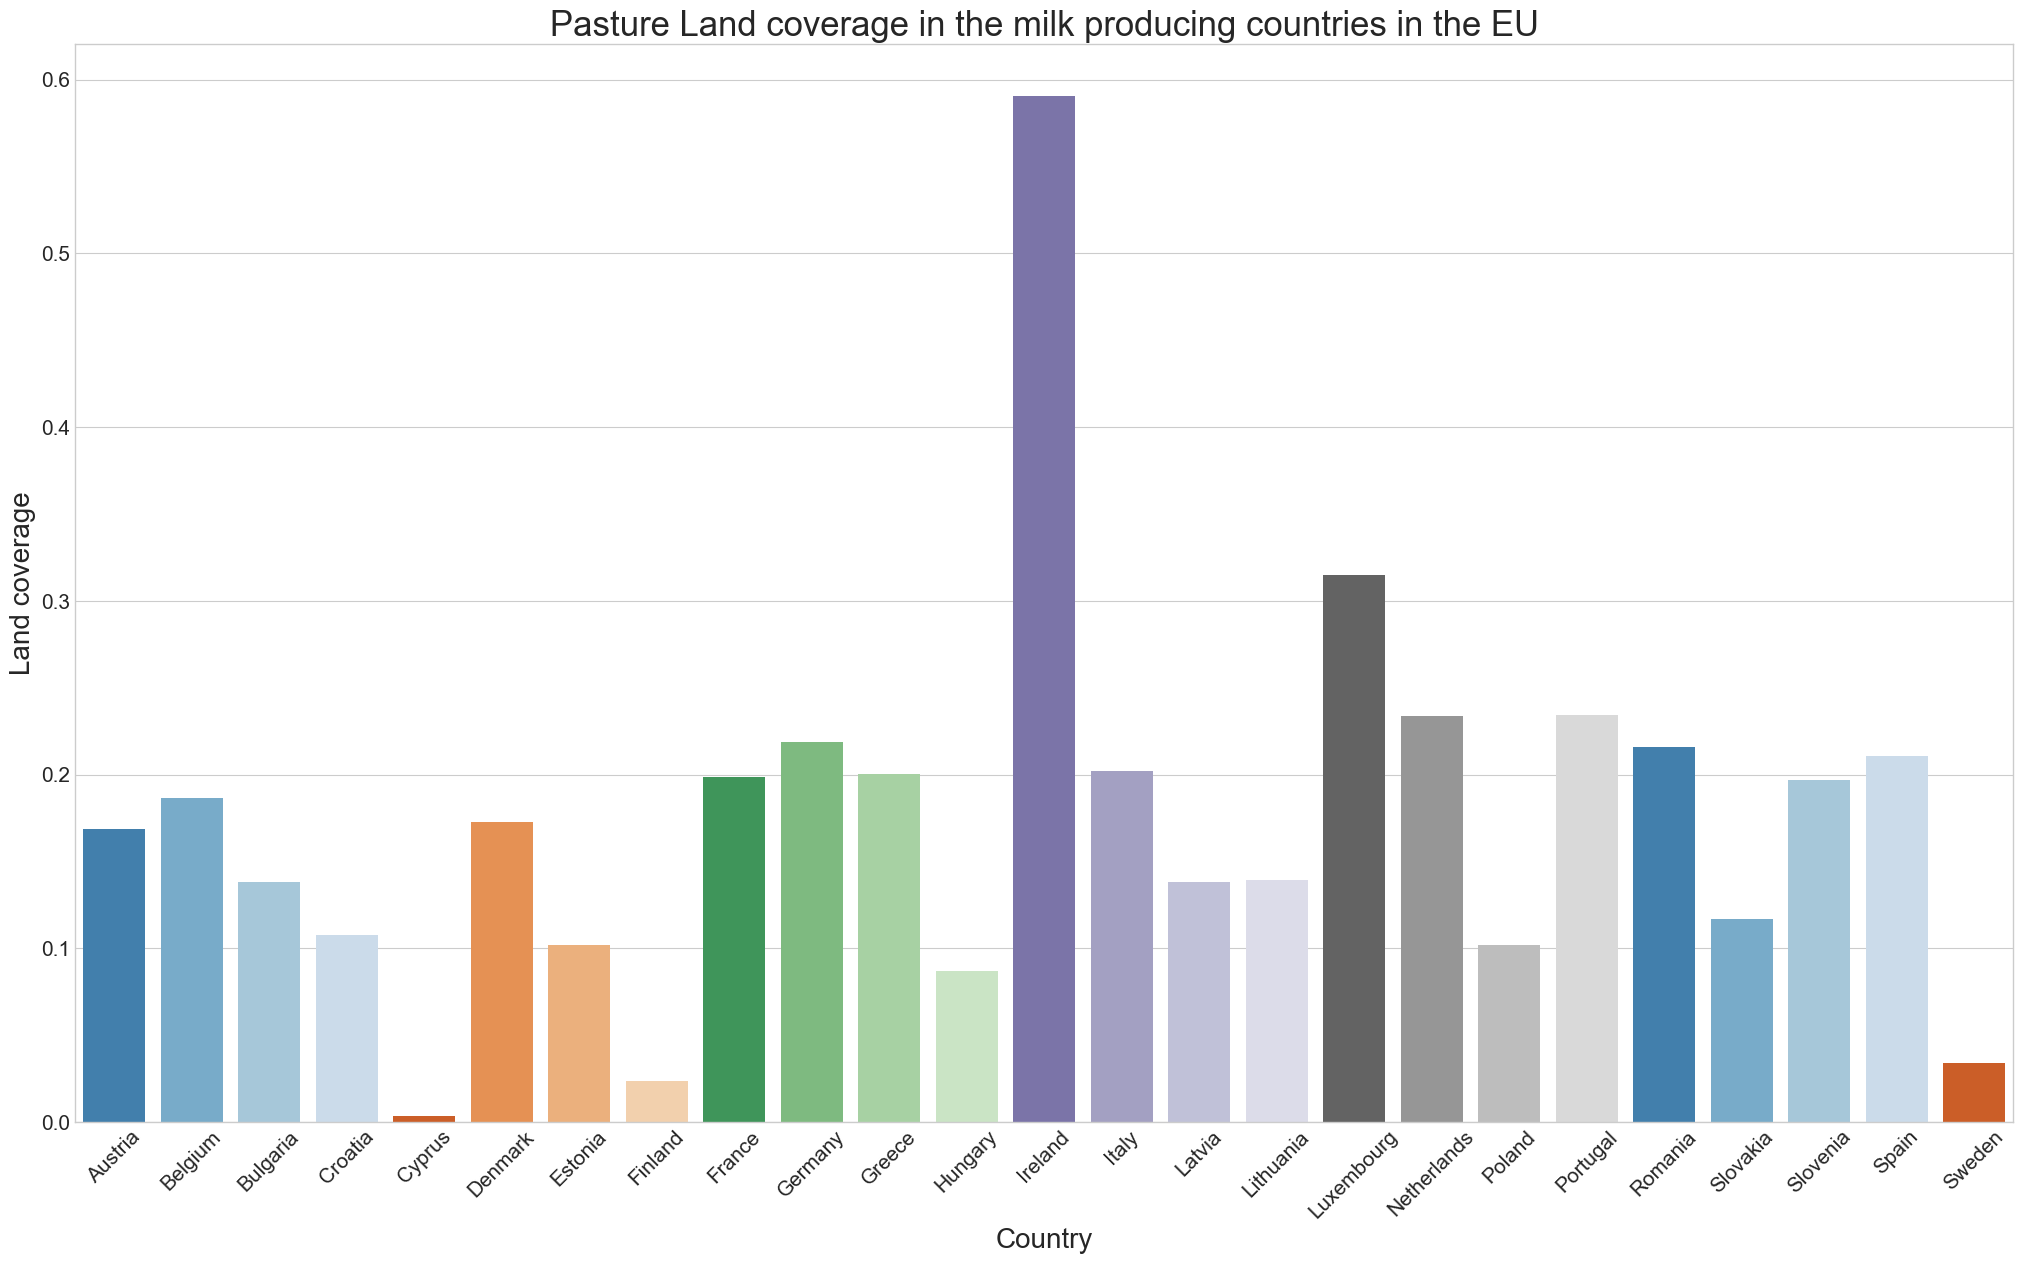

In [25]:
#creating a barchart of the land cover percentages
sns.barplot(x='Area', y='Percentage of pasture land', data=total_pasture[total_pasture.Year == 2020], palette = color)
plt.title('Pasture Land coverage in the milk producing countries in the EU', fontsize=25)
plt.xlabel('Country', fontsize=20)
plt.ylabel('Land coverage', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

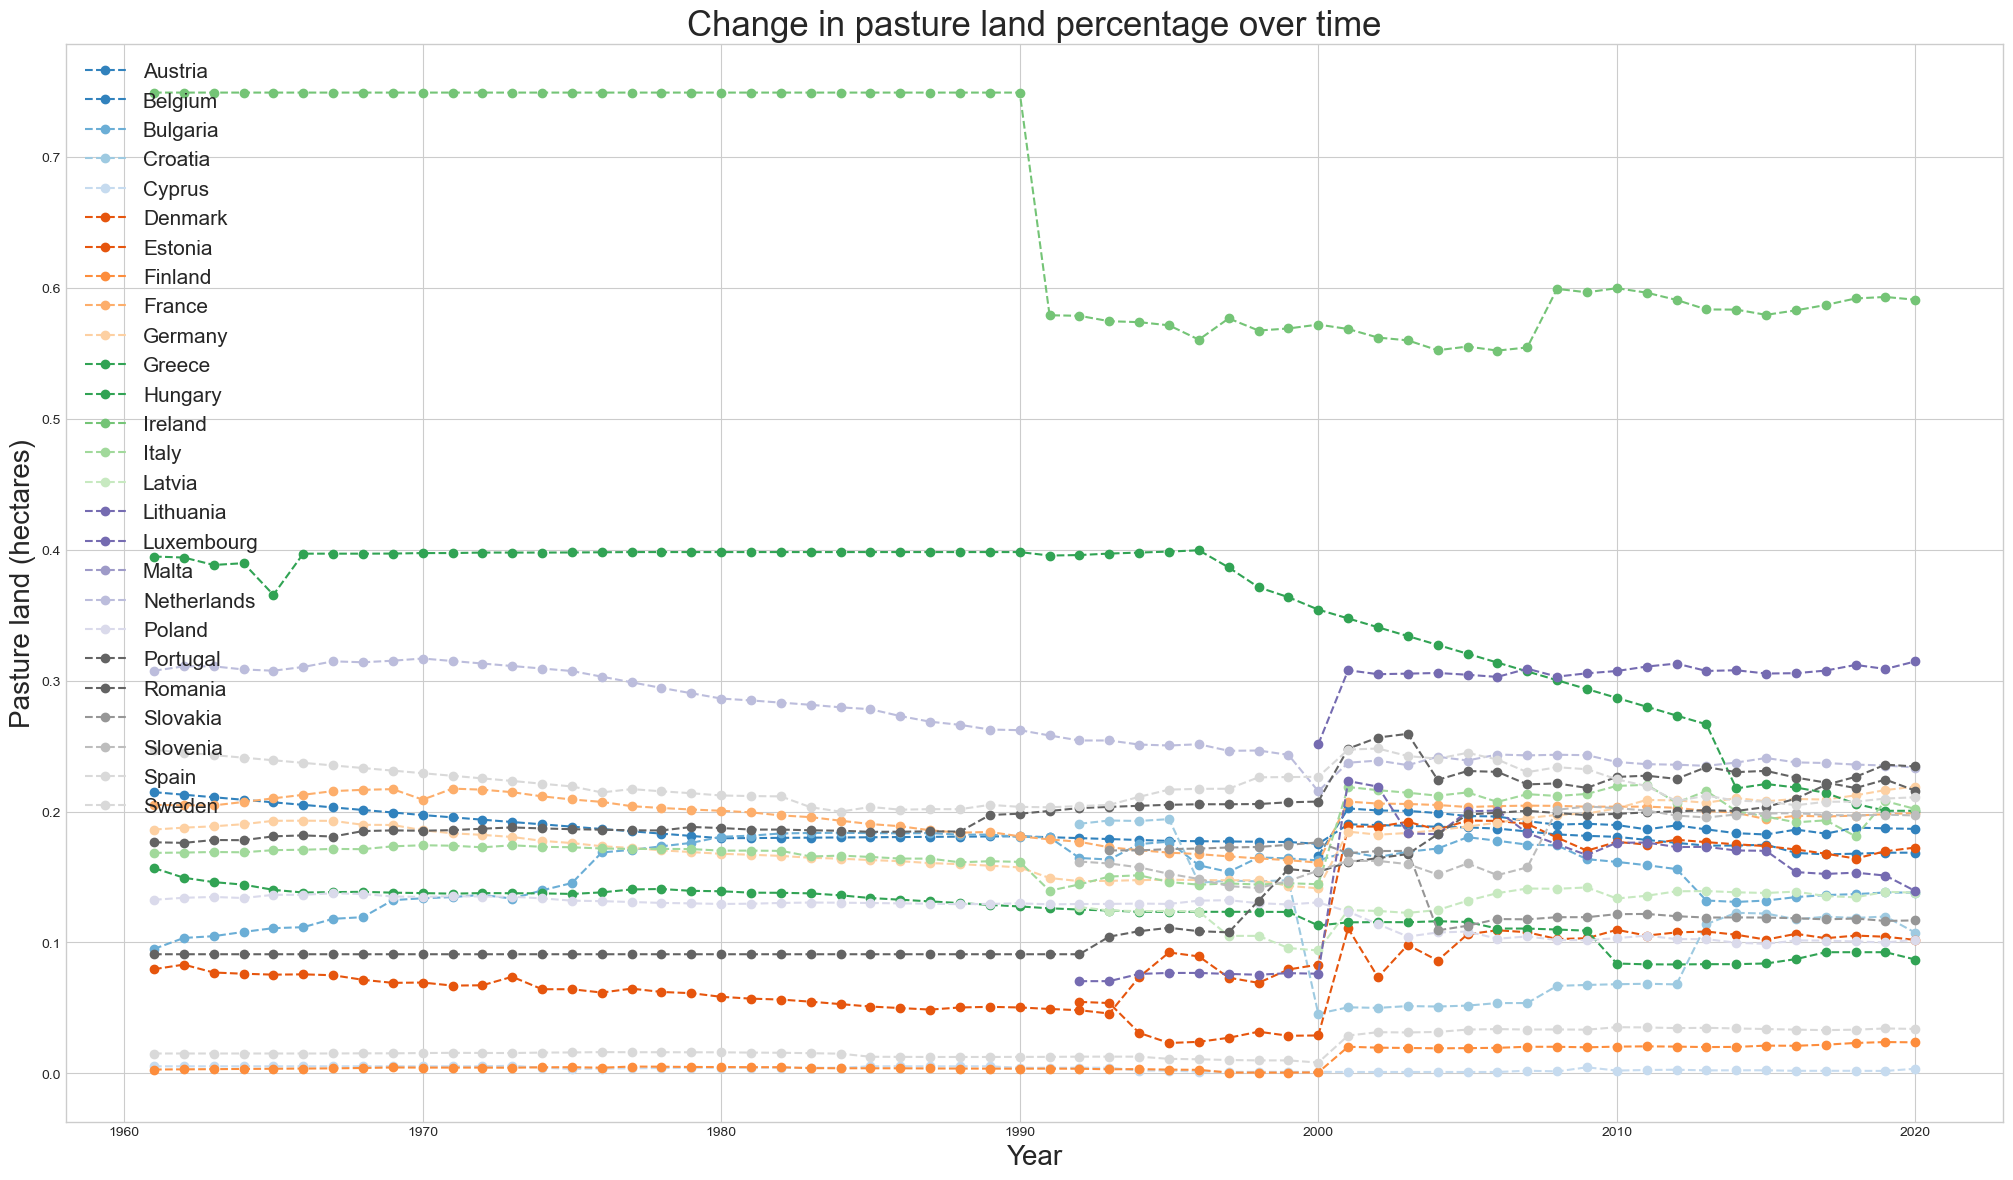

In [26]:
#plot change in pasture land over time
trend_plot(total_pasture, 'Percentage of pasture land', 'Change in pasture land percentage over time', 'Pasture land (hectares)')

In [27]:
total_pasture.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Year Code,Year,Unit,Permanent Pasture,Flag,Flag Description,key,Temporary Pasture,Total Pasture,Surface Area,Percentage of pasture land
0,RL,Land Use,40,Austria,5110,Area,6655,1961,1961,1000 ha,1801.4,A,Official figure,Austria1961,0.0,1801400.0,8387100,0.214782
1,RL,Land Use,40,Austria,5110,Area,6655,1962,1962,1000 ha,1785.0,A,Official figure,Austria1962,0.0,1785000.0,8387100,0.212827
2,RL,Land Use,40,Austria,5110,Area,6655,1963,1963,1000 ha,1768.8,A,Official figure,Austria1963,0.0,1768800.0,8387100,0.210895
3,RL,Land Use,40,Austria,5110,Area,6655,1964,1964,1000 ha,1752.5,A,Official figure,Austria1964,0.0,1752500.0,8387100,0.208952
4,RL,Land Use,40,Austria,5110,Area,6655,1965,1965,1000 ha,1736.2,A,Official figure,Austria1965,0.0,1736200.0,8387100,0.207008


In [28]:
#lets merge the total pasture, surface area, and percentage of pasture land to the milk_eu dataframe so that we only have one dataframe to work with
milk_eu = pd.merge(milk_eu, total_pasture[['key', 'Total Pasture', 'Surface Area', 'Percentage of pasture land']], on=['key'], how='inner')

In [29]:
milk_eu

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne,Country Code,volume,volume/cow,Total Pasture,Surface Area,Percentage of pasture land
0,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1961,1961,1127559.0,A,Official figure,Austria1961,2901500.0,AUT,2.825219e+09,2505.606434,1801400.0,8387100,0.214782
1,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1962,1962,1136353.0,A,Official figure,Austria1962,3004900.0,AUT,2.925901e+09,2574.816700,1785000.0,8387100,0.212827
2,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1963,1963,1124404.0,A,Official figure,Austria1963,3049200.0,AUT,2.969036e+09,2640.542036,1768800.0,8387100,0.210895
3,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1964,1964,1113920.0,A,Official figure,Austria1964,3127600.0,AUT,3.045375e+09,2733.926025,1752500.0,8387100,0.208952
4,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1965,1965,1110080.0,A,Official figure,Austria1965,3209200.0,AUT,3.124830e+09,2814.958923,1736200.0,8387100,0.207008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,QCL,Crops and livestock products,752,Sweden,5318,Milk Animals,2211.0,Raw milk of cattle,2016,2016,326122.0,A,Official figure,Sweden2016,2862000.0,SWE,2.786758e+09,8545.138158,1504500.0,45029500,0.033411
1231,QCL,Crops and livestock products,752,Sweden,5318,Milk Animals,2211.0,Raw milk of cattle,2017,2017,326440.0,A,Official figure,Sweden2017,2816660.0,SWE,2.742610e+09,8401.573160,1488050.0,45029500,0.033046
1232,QCL,Crops and livestock products,752,Sweden,5318,Milk Animals,2211.0,Raw milk of cattle,2018,2018,313050.0,A,Official figure,Sweden2018,2760230.0,SWE,2.687663e+09,8585.411584,1503530.0,45029500,0.033390
1233,QCL,Crops and livestock products,752,Sweden,5318,Milk Animals,2211.0,Raw milk of cattle,2019,2019,301380.0,A,Official figure,Sweden2019,2704390.0,SWE,2.633291e+09,8737.444884,1545780.0,45029500,0.034328


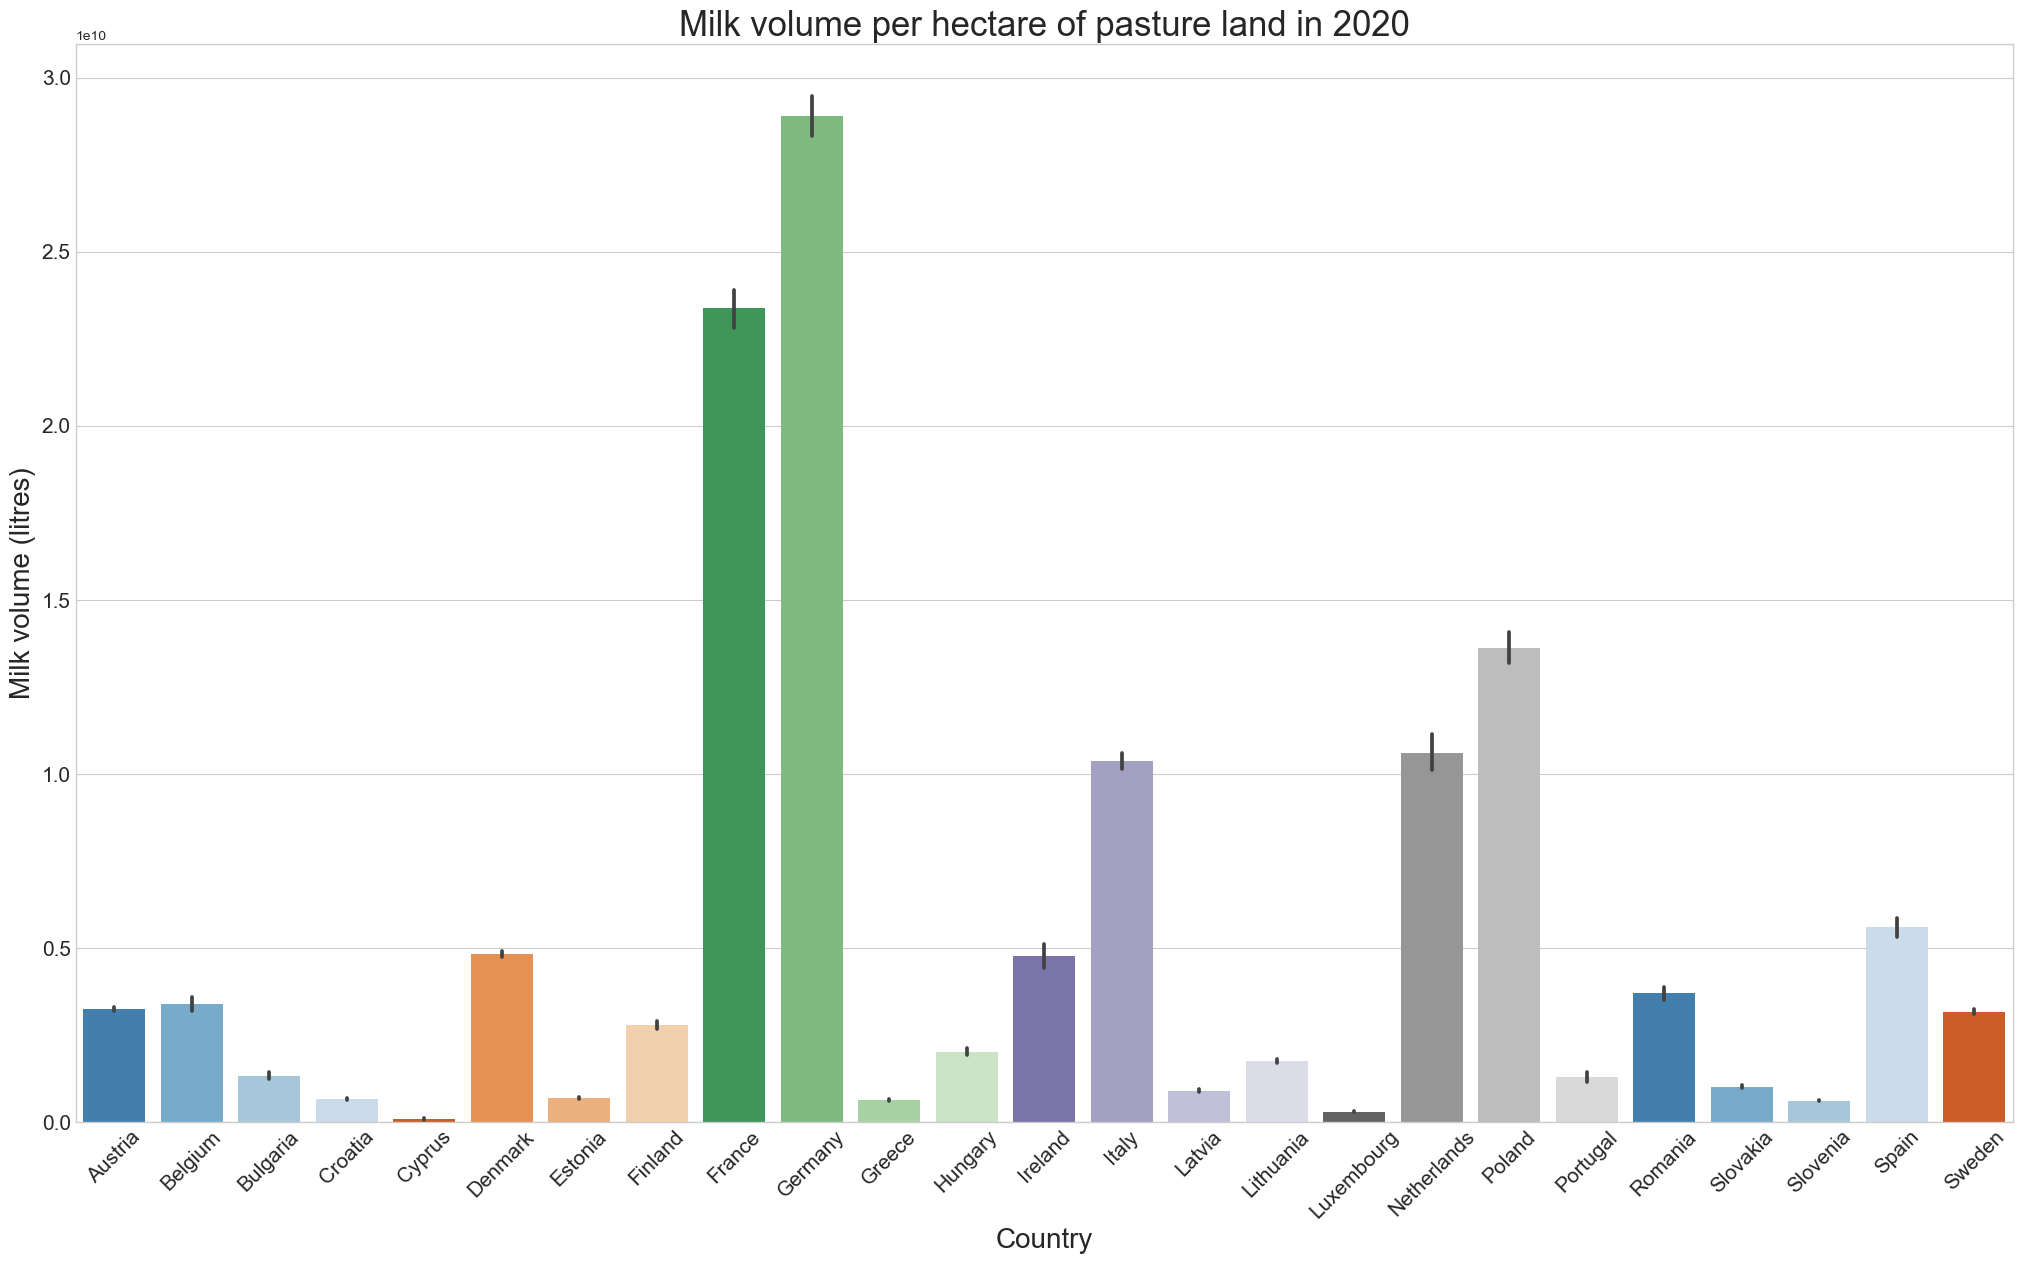

In [30]:
#pot a barplot for the milk volume per hectare of pasture land in 2020
sns.barplot(x='Area', y='volume', data=milk_eu, palette = color)
plt.title('Milk volume per hectare of pasture land in 2020', fontsize=25)
plt.xlabel('Country', fontsize=20)
plt.ylabel('Milk volume (litres)', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [31]:
#we want to filter the dataframe by countries
price_df = price_df[price_df['Area'].isin(countries)]
#the prices are given as usd per tonne, we wnat to make a new clumn that is usd per litre
price_df['Price per litre(USD)'] = price_df['Value']/(1000/1.027)#converting to litres from tonnes
#filter the Months column to show only annual value
price_df = price_df[price_df['Months'] == 'Annual value']
price_df


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description,Price per litre(USD)
0,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1991,1991,7021,Annual value,USD,454.8,A,Official figure,0.467080
1,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1992,1992,7021,Annual value,USD,499.6,A,Official figure,0.513089
2,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1993,1993,7021,Annual value,USD,468.6,A,Official figure,0.481252
3,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1994,1994,7021,Annual value,USD,478.9,A,Official figure,0.491830
4,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1995,1995,7021,Annual value,USD,372.9,A,Official figure,0.382968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,PP,Producer Prices,752,Sweden,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,2016,2016,7021,Annual value,USD,360.5,A,Official figure,0.370233
755,PP,Producer Prices,752,Sweden,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,2017,2017,7021,Annual value,USD,448.7,A,Official figure,0.460815
756,PP,Producer Prices,752,Sweden,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,2018,2018,7021,Annual value,USD,461.2,A,Official figure,0.473652
757,PP,Producer Prices,752,Sweden,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,2019,2019,7021,Annual value,USD,418.3,A,Official figure,0.429594


In [32]:
#make a key column to merge the data
price_df['key'] = price_df['Area'] + price_df['Year'].astype(str)
#merge the data onto the milk_euy dataframe
milk_eu = pd.merge(milk_eu[milk_eu.Year > 1990], price_df[['key', 'Price per litre(USD)']], on='key', how='inner')


In [33]:
milk_eu.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne,Country Code,volume,volume/cow,Total Pasture,Surface Area,Percentage of pasture land,Price per litre(USD)
0,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1991,1991,865392.0,A,Official figure,Austria1991,3329700.0,AUT,3.242162e+09,3746.465920,1512900.0,8387100,0.180384,0.467080
1,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1992,1992,841099.0,A,Official figure,Austria1992,3286583.0,AUT,3.200178e+09,3804.758047,1507000.0,8387100,0.179681,0.513089
2,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1993,1993,817935.0,A,Official figure,Austria1993,3269622.0,AUT,3.183663e+09,3892.317967,1501000.0,8387100,0.178965,0.481252
3,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1994,1994,804264.0,A,Official figure,Austria1994,3278429.0,AUT,3.192239e+09,3969.142668,1495100.0,8387100,0.178262,0.491830
4,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1995,1995,638339.0,A,Official figure,Austria1995,2948170.0,AUT,2.870662e+09,4497.080897,1489100.0,8387100,0.177546,0.382968


In [34]:
#lets add in another column that will give the total revenue per country
milk_eu['Revenue'] = milk_eu['volume']*milk_eu['Price per litre(USD)']
milk_eu.shape

(711, 23)

In [35]:
export_df

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,40,Austria,5910,Export Quantity,2211,Raw milk of cattle,1961,1961,tonnes,18423.0,A,Official figure
1,TCL,Crops and livestock products,40,Austria,5910,Export Quantity,2211,Raw milk of cattle,1962,1962,tonnes,18793.0,A,Official figure
2,TCL,Crops and livestock products,40,Austria,5910,Export Quantity,2211,Raw milk of cattle,1963,1963,tonnes,16614.0,A,Official figure
3,TCL,Crops and livestock products,40,Austria,5910,Export Quantity,2211,Raw milk of cattle,1964,1964,tonnes,11974.0,A,Official figure
4,TCL,Crops and livestock products,40,Austria,5910,Export Quantity,2211,Raw milk of cattle,1965,1965,tonnes,11660.0,A,Official figure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,TCL,Crops and livestock products,752,Sweden,5922,Export Value,2211,Raw milk of cattle,2016,2016,1000 US$,9551.0,A,Official figure
2700,TCL,Crops and livestock products,752,Sweden,5922,Export Value,2211,Raw milk of cattle,2017,2017,1000 US$,10348.0,A,Official figure
2701,TCL,Crops and livestock products,752,Sweden,5922,Export Value,2211,Raw milk of cattle,2018,2018,1000 US$,4732.0,A,Official figure
2702,TCL,Crops and livestock products,752,Sweden,5922,Export Value,2211,Raw milk of cattle,2019,2019,1000 US$,5328.0,A,Official figure


In [36]:
#looking at export data
#filter export to show only eu countries and export value
value_df = export_df[(export_df['Area'].isin(countries)) & (export_df.Element == 'Export Value')]
#make key column to merge the data
value_df['key'] = value_df['Area'] + value_df['Year'].astype(str)

#filter export to show only eu countries and export quantity
amount_df = export_df[(export_df['Area'].isin(countries)) & (export_df.Element == 'Export Quantity')]
#make key column to merge the data
amount_df['key'] = amount_df['Area'] + amount_df['Year'].astype(str)

#remane value in the value_df to export value
value_df.rename(columns={'Value': 'Export Value'}, inplace=True)
#rename value in the amount_df to export quantity(T)
amount_df.rename(columns={'Value': 'Export Quantity(T)'}, inplace=True)

#merge the dataframes
export_info_df = pd.merge(value_df, amount_df[['key', 'Export Quantity(T)']], on='key', how='inner')
#add a column that has export value in usd
export_info_df['Export Value(USD)'] = export_info_df['Export Value']*1000

#merge this onto the milk_eu dataframe
milk_eu = pd.merge(milk_eu, export_info_df[['key', 'Export Value(USD)', 'Export Quantity(T)']], on='key', how='inner')

In [40]:
milk_eu.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne,Country Code,volume,volume/cow,Total Pasture,Surface Area,Percentage of pasture land,Price per litre(USD),Revenue,Export Value(USD),Export Quantity(T)
0,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1991,1991,865392.0,A,Official figure,Austria1991,3329700.0,AUT,3.242162e+09,3746.465920,1512900.0,8387100,0.180384,0.467080,1.514348e+09,2543000.0,3430.0
1,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1992,1992,841099.0,A,Official figure,Austria1992,3286583.0,AUT,3.200178e+09,3804.758047,1507000.0,8387100,0.179681,0.513089,1.641977e+09,3884000.0,4879.0
2,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1993,1993,817935.0,A,Official figure,Austria1993,3269622.0,AUT,3.183663e+09,3892.317967,1501000.0,8387100,0.178965,0.481252,1.532145e+09,2992000.0,3960.0
3,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1994,1994,804264.0,A,Official figure,Austria1994,3278429.0,AUT,3.192239e+09,3969.142668,1495100.0,8387100,0.178262,0.491830,1.570040e+09,2645000.0,3356.0
4,QCL,Crops and livestock products,40,Austria,5318,Milk Animals,2211.0,Raw milk of cattle,1995,1995,638339.0,A,Official figure,Austria1995,2948170.0,AUT,2.870662e+09,4497.080897,1489100.0,8387100,0.177546,0.382968,1.099373e+09,29680000.0,63851.0
